In [23]:
import os, pickle
from collections import Counter
from tqdm import tqdm

source = os.path.join('data', 'output', 'old_round_0','self_play')
dest = os.path.join('data','output','new_round_0','self_play')
tournamentfiles = [f for f in os.listdir(source) if f.startswith('tmnt_') and f.endswith('.pkl')]

for file in tqdm(tournamentfiles):

    with open(os.path.join(source, file), 'rb') as pkl:
        old_tourn = pickle.load(pkl)

    new_tourn = {
        pair: {
            'a0wa1b': {
                'white': {
                    'points': old_tourn[pair][0]['white']['points'], 
                    'moves': old_tourn[pair][0]['white']['moves']
                }, 
                'black': {
                    'points': old_tourn[pair][0]['black']['points'], 
                    'moves': old_tourn[pair][0]['black']['moves']
                }
            },
            'a1wa0b': {
                'white': {
                    'points': old_tourn[pair][1]['white']['points'], 
                    'moves': old_tourn[pair][1]['white']['moves']
                }, 
                'black': {
                    'points': old_tourn[pair][1]['black']['points'], 
                    'moves': old_tourn[pair][1]['black']['moves']
                }
            }
        } for pair in old_tourn
    }

    with open(os.path.join(dest, file), 'wb') as pkl:
        pickle.dump(new_tourn, pkl)

  1%|▏         | 8/591 [00:00<00:07, 72.97it/s]

100%|██████████| 591/591 [00:07<00:00, 83.70it/s] 


In [30]:
import os, pickle
from collections import Counter
from tqdm import tqdm
from chess_primitives import conjugate_board, board_token

def harvest_checkmates(self_play_dirs):
    checkmates = []

    for source in self_play_dirs:
        tournamentfiles = [f for f in os.listdir(source) if f.startswith('tmnt_') and f.endswith('.pkl')]

        for file in tournamentfiles:

            with open(os.path.join(source, file), 'rb') as pkl:
                tourn = pickle.load(pkl)

            for i, pair in tourn.items():
                for order,game in pair.items():
                    for color in game:
                        if game[color]['points'] == 1: # This game was won by this color
                            winning_token, winning_board = game[color]['moves'][-1] # The last move made by the winning color - checkmate
                            checkmates.append((winning_token, winning_board, 1)) # Winning board
                            # construct losing board as well
                            losing_color = 'black' if color == 'white' else 'white'
                            losing_board = conjugate_board(winning_board)
                            losing_token = board_token(losing_board, f'{losing_color}E_')
                            checkmates.append((losing_token, losing_board, -1))
    return checkmates

In [31]:
self_play_dirs = [os.path.join('data','output','new_round_0','self_play'), os.path.join('data','output','round_1','self_play')]

checkmates = harvest_checkmates(self_play_dirs)

In [5]:
import os
baseline_root = os.path.join('data','output_old','new_round_0','self_play')
baseline_tournament_files = os.listdir(baseline_root)

round1_root = os.path.join('data','output_old','round_1','self_play')
round1_tournament_files = os.listdir(round1_root)

In [6]:
len(baseline_tournament_files) + len(round1_tournament_files)

827

In [8]:
print(len(baseline_tournament_files))
print(len(round1_tournament_files))

591
236


In [36]:
working_dir = os.path.join('data','output')

new_dirs = [f'round_{i}' for i in range(10)]
for d in new_dirs:
    os.mkdir(os.path.join(working_dir, d, 'self_play'))

In [14]:
591 / 7

84.42857142857143

In [23]:
baseline_splits = [84] * 6 + [87]
print(len(baseline_splits))
print(sum(baseline_splits))

7
591


In [25]:
round1_splits = [78] * 2 + [80]
print(len(round1_splits))
print(sum(round1_splits))

3
236


In [35]:
import pickle

baseline_files_processed = 0
baseline_file_batches = []
for split in baseline_splits:
    files_to_move = baseline_tournament_files[baseline_files_processed: baseline_files_processed+split]
    baseline_file_batches.append(files_to_move)
    baseline_files_processed += split

round1_files_processed = 0
round1_file_batches = []
for split in round1_splits:
    files_to_move = round1_tournament_files[round1_files_processed: round1_files_processed+split]
    round1_file_batches.append(files_to_move)
    round1_files_processed += split

for i,batch in enumerate(baseline_file_batches, start=0):
    dest_dir = os.path.join(working_dir, f'round_{i}')

    for file in batch:
        with open(os.path.join(baseline_root, file), 'rb') as pkl:
            tourn = pickle.load(pkl)

        with open(os.path.join(dest_dir, file), 'wb') as pkl:
            pickle.dump(tourn, pkl)

for i,batch in enumerate(round1_file_batches, start=7):
    dest_dir = os.path.join(working_dir, f'round_{i}')

    for file in batch:
        with open(os.path.join(round1_root, file), 'rb') as pkl:
            tourn = pickle.load(pkl)

        with open(os.path.join(dest_dir, file), 'wb') as pkl:
            pickle.dump(tourn, pkl)

In [38]:
from chess_selfplay import harvest_checkmates
from tqdm import tqdm

working_dir = os.path.join('data','output')

new_dirs = [f'round_{i}' for i in range(10)]

for dir in tqdm(new_dirs):
    _ = harvest_checkmates(os.path.join(working_dir,dir))

100%|██████████| 10/10 [00:01<00:00,  9.71it/s]


In [ ]:
import os, pickle
from collections import Counter
from tqdm import tqdm

root = os.path.join('data', 'output', 'round_0','self_play')
tournamentfiles = [f for f in os.listdir(root) if f.startswith('tmnt_') and f.endswith('.pkl')]
agent0_points = []
agent1_points = []
checkmates = []

for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)
    
    for i, pair in tourn.items():
        agent0_points.append(pair['a0wa1b']['white']['points'])
        agent1_points.append(pair['a0wa1b']['black']['points'])
        agent0_points.append(pair['a1wa0b']['black']['points'])
        agent1_points.append(pair['a1wa0b']['white']['points'])
        for order,game in pair.items():
            for color in game:
                if abs(game[color]['points']) == 1:
                    token, board = game[color]['moves'][-1]
                    points = game[color]['points']
                    checkmates.append((token, board, points))

print(f'{len(checkmates)/2:.0f} games ended in checkmate out of {len(tournamentfiles)*2:.0f} games played.')
Counter(agent0_points)

In [10]:
import os, pickle
from collections import Counter
from tqdm import tqdm
root = os.path.join('data', 'output', 'round_1','self_play')
chkm_dest = os.path.join('data', 'output', 'checkmates','baseline')

tournamentfiles = [f for f in os.listdir(root) if f.startswith('tmnt_') and f.endswith('.pkl')]
supplementary_checkmates = os.listdir(chkm_dest)
positions = dict()

for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)

    for i, pair in tourn.items():
        for order,game in pair.items():
            for color in game:
                points = game[color]['points']
                for token, move in game[color]['moves']:
                    token, board = game[color]['moves'][-1]
                    if token in positions:
                        positions[token]['visits'] += 1
                        positions[token]['points'] += points
                    else:
                        positions[token] = {'board':board, 'visits':1, 'points':points}

for file in supplementary_checkmates:
    with open(os.path.join(chkm_dest, file), 'rb') as pkl:
        token, board, points = pickle.load(pkl)
    if token not in positions:
        positions[token] = {'board':board, 'visits':1, 'points':points}

print(len(positions))
    

2191


(array([ 405.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 1786.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

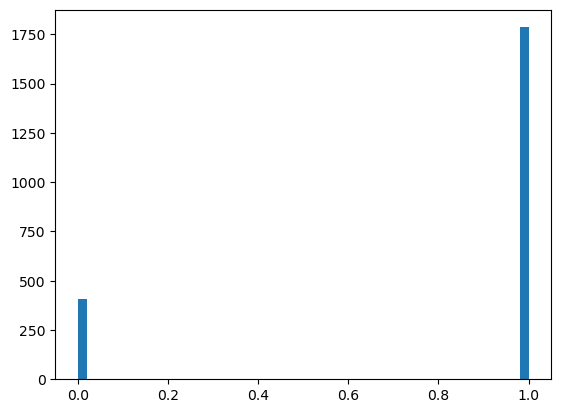

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(np.array([abs(position['points']/position['visits']) for position in positions.values()]), bins=50)

Text(0.5, 0, 'Number of moves made')

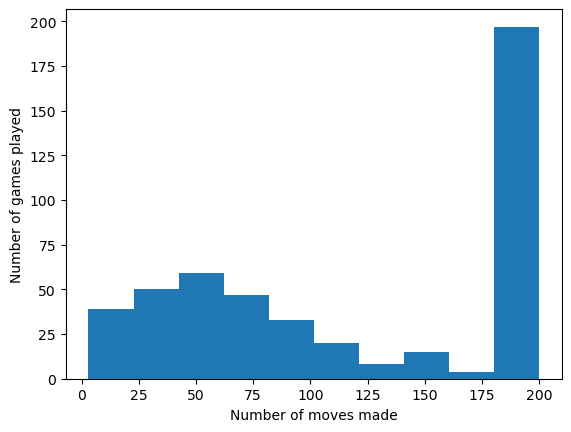

In [12]:
num_moves = []
for file in tournamentfiles:
    with open(os.path.join(root, file), 'rb') as pkl:
        tourn = pickle.load(pkl)

    for i, pair in tourn.items():
        for order,game in pair.items():
            nmoves = max(len(game['white']['moves']), len(game['black']['moves']))
            num_moves.append(nmoves)

plt.hist(num_moves)
plt.ylabel('Number of games played')
plt.xlabel('Number of moves made')
